# Note:
- This notebook file may contain methods or algorithms that are NOT covered by the teaching content of BT4222 and hence will not be assessed in your midterm exam.
- It serves to increase your exposure in depth and breath to the practical methods in addressing the specific project topic. We believe it will be helpful for your current project and also your future internship endeavors.

# LSTM for sentiment analysis

This notebook provides an example of applying LSTM to imdb dataset based on pytorch. We adopted this [tutorial](https://medium.com/@khang.pham.exxact/hugging-face-text-classification-tutorial-using-pytorch-cd3d6bc33292) for this part. The dataset is only a subset of the original IMDB dataset for the convenience of reproducing with limited computing resource, so the accuracy would be lower.

## Agenda

1. Preparation and Data Loading
2. Tokenization and Padding
3. Batching and loading as tensor
4. Model structure
5. Training and evaluation


## Part 1: Preparation and data loading
We are going to Import the Necessary Libraries and Check if CUDA is Available for preparation stage.

During this tutorial, most of the libraries used here will hopefully become more clear, but to begin we' ll explain some of the main libraries that were just imported:

`NumPy`: freely create arrays and matrices. It also contains multiple linear algebra functions.

`sklearn`: import and utilize the train_test_split function. This function allows us to split our data into both a training and testing data set. You can choose the ratio of the split, among other parameters, but more on that later.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

Then, we check if a GPU is available to run or code on. If no GPU is provided then the code will process on a normal CPU.

In [ ]:
# Check cuda status
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


### Data loading:
- Load the whole dataset in csv format
- Split it into training and testing data. Doing this on earlier stage allows to avoid data lekage.
- In `train_test_split` function, you can passed extra parameters like `test_size`: by passing a value of 0.2 we are instructing the train_test_split function to split our data set into 80% training and 20% testing sets.

In [ ]:
from google.colab import drive

import gdown

file_id = '1TPneTNMGP0tHQ94QxANmrkBtItgKG1Px'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'Test.csv'
gdown.download(url, output, quiet=False)


base_csv = 'Test.csv'
df = pd.read_csv(base_csv)

X,y = df['text'].values,df['label'].values
# drop a bunch of unrelated columns which are unnecessary for our model to work and are only slowing it down.
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y, test_size=0.2)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

Downloading...
From: https://drive.google.com/uc?id=1TPneTNMGP0tHQ94QxANmrkBtItgKG1Px
To: /content/Test.csv
100%|██████████| 6.61M/6.61M [00:00<00:00, 183MB/s]

shape of train data is (4000,)
shape of test data is (1000,)


## Part 2: Tokenization and Padding
**Tokenization**

In this step we preprocess the string, remove stopwords and tokenize.

Tokenization is the process of breaking down a piece of text into smaller units called tokens. These tokens can be words, subwords, or even characters, depending on the specific tokenization approach used. Tokenization is an essential step in natural language processing tasks as it helps to structure and analyze text data.

The main concept behind tokenization is that by analyzing the different words present in a given text, we can interpret the meaning of such a text. We can also run statistical tools and methods to find hidden insights and patterns in the data.

*In our tutorial of machine learning methods, we directly use a tokenizer in a well-developed library. Here, we provide an example of implementing a simple tokenizer from scratch.*

**Several reasons for choosing 1000(or another value) most common words in the vocabulary:**
 - Reduction of Dimensionality and Complexity: Natural language contains a vast number of words, but not all words are equally important for a given task.

 - Frequency and Information Content: Common words often have higher frequencies in the corpus. Consequently, they carry more information. For most NLP tasks, the semantics and contextual relationships of these common words are easier for models to capture, leading to improved performance.

 - Data Sparsity: In a large vocabulary, many words might appear very infrequently, or even just once.

- Reducing Noise Impact: Large-scale corpora can contain errors, misspellings, low-frequency words, or irrelevant terms. Selecting common words helps mitigate the impact of such noise on the model.

The choice of vocabulary size should be adjusted based on the specifics of the task and dataset. A small vocabulary might limit a model's capabilities, while a large vocabulary might increase computational costs.

In [ ]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        # print(type(sent)) 'str'
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    # sorting on the basis of 1000 most common words.
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])

    return np.array(final_list_train, dtype=object), np.array(final_list_test, dtype=object), onehot_dict

nltk.download('stopwords')
x_train,x_test,vocab = tockenize(x_train,y_train,x_test,y_test)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now with every word tokenized, we can get the length of the vocabulary.

In [ ]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


We can analyze and visualize the length of preprocessed text.

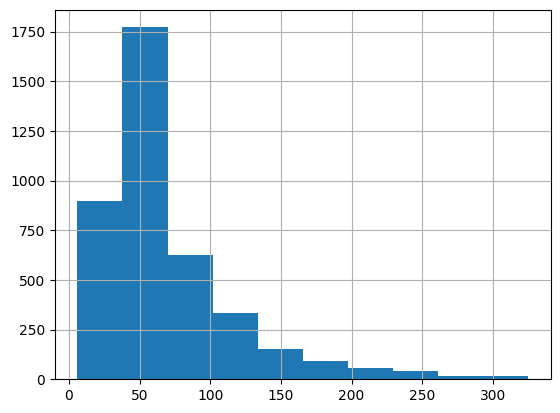

count    4000.000000
mean       68.986000
std        48.437412
min         6.000000
25%        39.000000
50%        54.000000
75%        83.000000
max       325.000000
dtype: float64

In [ ]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()


 **Padding**

 To ensure uniform sequence length for batch processing, we pad the text.

Text data often varies in sentence or document length, but language models typically require fixed-length input sequences consisting of N tokens. Padding is used to address this issue by adding special padding tokens at the end of shorter sequences, making them all the same length. This allows multiple sequences to be placed in a batch and efficiently processed in parallel since they have the same length. During model processing, it learns to ignore padding tokens and focus only on the meaningful input tokens, thus not being affected by the padding. In summary, padding text sequences aims to achieve consistent sequence length for batch processing without impacting the model's ability to learn from actual information.

We perform padding on the X values in the training and testing data set. Since most reviews have a length of below 500, we will only consider sentences below the 500 range.

In [ ]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

## Part 3: Batching and loading as tensor


In [ ]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [ ]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample sentences x: \n', sample_x)
print('Sample targets y: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ..., 447, 102,  11],
        [  0,   0,   0,  ..., 554, 286, 244],
        [  0,   0,   0,  ..., 353, 410, 123],
        ...,
        [  0,   0,   0,  ...,   8, 221, 175],
        [  0,   0,   0,  ..., 104, 170, 422],
        [  0,   0,   0,  ...,   2, 187, 204]])
Sample input: 
 tensor([1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 0])


## Part 4: Model structure

We need to add an embedding layer because there are less words in our vocabulary. It is massively inefficient to one-hot encode that many classes. So, instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table. You could train an embedding layer using Word2Vec, then load it here. But, it's fine to just make a new layer, using it for only dimensionality reduction, and let the network learn the weights.

**Common Steps for Model Initialization:**
1. Define Model architecture
2. Create model instance
3. Move model to device
4. Define loss function
5. Choose optimizer


In [ ]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)


        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        # print(embeds.shape)  #[50, 500, 64]; 64 is the embedding_dim defined below.
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden



    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

Define the hyperparameters and pass to the model.

In [ ]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


We set the learning rate and optimizer. Use accuracy as the metric.

In [ ]:
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

## Part 5: Training and evaluation

Here is a training loop. It iterates through each training epoch, and at the end of each epoch, it displays the training and validation losses along with the accuracy.

**Steps Involved in Training:**
1. Loop Through Epochs: Set the number of training epochs and loop through them.

2. Set Model to Train Mode: Put the model in training mode using .train(). This enables layers like dropout to work during training.

3. Initialize Hidden States: For each epoch, initialize the hidden and cell states of the LSTM layers before processing a new sequence.

4. Loop Through Batches: Iterate through batches of training data.

5. Zero Gradients: Before each batch, zero out the gradients of the model's parameters using .zero_grad().

6. Forward Pass: Pass the input sequence through the LSTM model to obtain predictions.

7. Calculate Loss: Calculate the loss between the predictions and the actual target values using the chosen loss function.

8. Backpropagation: Perform backpropagation to compute gradients of the loss with respect to the model's parameters.

9. Gradient Clipping: Apply gradient clipping to prevent exploding gradients, especially in RNNs like LSTMs.

10. Optimizer Step: Update the model's parameters using the chosen optimizer's .step() method.

**Steps Involved in Evaluation:**
1. Set Model to Evaluation Mode: Put the model in evaluation mode using .eval(). This disables layers like dropout during evaluation.

2. Initialize Hidden States: Initialize the hidden and cell states of the LSTM layers before processing each sequence.

3. Loop Through Test Data: Iterate through batches of test data.

4. Forward Pass: Pass the input sequence through the model to obtain predictions.

5. Calculate Loss or Metrics: Calculate loss or any evaluation metrics appropriate for your task (accuracy, F1-score, etc.).

6. Aggregate Metrics: Calculate and aggregate metrics across all test batches to get an overall performance measure.

In [ ]:
# set the gradient clipping threshold and number of training epochs
clip = 5
epochs = 20

# Initialize the minimum validation loss as positive infinity
valid_loss_min = np.Inf

epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    # set the model to training mode
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # Clear the gradients
        model.zero_grad()
        # Perform a forward pass through the model
        output,h = model(inputs,h)

        # calculate the loss and perform backpropogation
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())

        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        # Gradient Clipping: `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        # Optimizer Step: Update the model's parameters using the optimizer
        optimizer.step()


    # validation
    # Set Model to Evaluation Mode
    model.eval()
    # Initialize Hidden States
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    # Loop Through Test Data
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)
            # Forward Pass
            output, val_h = model(inputs, val_h)

            # Calculate Loss and Metrics(Accuracy)
            val_loss = criterion(output.squeeze(), labels.float())
            val_losses.append(val_loss.item())
            accuracy = acc(output,labels)
            val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    # Aggregate Metrics
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    print(25*'==')

Epoch 1
train_loss : 0.6601921334862709 val_loss : 0.5948982119560242
train_accuracy : 59.75 val_accuracy : 68.0
Epoch 2
train_loss : 0.5558413974940777 val_loss : 0.5302614092826843
train_accuracy : 72.7 val_accuracy : 75.1
Epoch 3
train_loss : 0.4677178584039211 val_loss : 0.46618108451366425
train_accuracy : 78.325 val_accuracy : 77.8
Epoch 4
train_loss : 0.4355272766202688 val_loss : 0.4870410054922104
train_accuracy : 81.3 val_accuracy : 77.4
Epoch 5
train_loss : 0.3629693147726357 val_loss : 0.48650067672133446
train_accuracy : 85.0 val_accuracy : 77.3
Epoch 6
train_loss : 0.303387201204896 val_loss : 0.5234006613492965
train_accuracy : 87.47500000000001 val_accuracy : 77.5
Epoch 7
train_loss : 0.27275250852108 val_loss : 0.6018998607993126
train_accuracy : 89.0 val_accuracy : 80.2
Epoch 8
train_loss : 0.2096931732259691 val_loss : 0.5993746384978295
train_accuracy : 91.77499999999999 val_accuracy : 80.7
Epoch 9
train_loss : 0.12691445399541407 val_loss : 0.7711191713809967
train